In [1]:
import or_gym
from or_gym.benchmarks.inv_management.oim_benchmark import *
import matplotlib.pyplot as plt
# plt.style.use('c:/users/hd/.matplotlib/stylelib/orgym.py')
import pyomo.environ as pe
import pickle

### Run backlog cases

In [2]:
for per in [30]:
    print("Period "+str(per))
    for i in range(10):
        print("Run "+str(i))
        #create environments for 5 cases
        seed_train = np.random.randint(1000)
        seed_sim = np.random.randint(1000)
        print("Seed for simulation "+str(seed_sim))

        env1_mip_dyn=or_gym.make("InvManagement-v0",env_config={'seed_int':seed_sim,'periods':per})

        #run optimizations for backlog scenario
        env1_mip_dyn_actions, _ = online_optimize_dyn_im_mip(env1_mip_dyn, print_results = True)

        #PICKLE
        NV_envs = {'Dynamic':env1_mip_dyn,
                   'Dynamic R':env1_mip_dyn_actions}
        file_env = open('NV_Backlog_dyn_'+str(per)+'_'+str(i)+'.obj','wb')
        pickle.dump(NV_envs,file_env)
        file_env.close()

ange        [1e+00, 4e+02]
Presolve removed 418 rows and 331 columns
Presolve time: 0.00s
Presolved: 87 rows, 102 columns, 369 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6525692e+01   7.938297e+02   0.000000e+00      0s
      57   -3.3284754e+00   0.000000e+00   0.000000e+00      0s

Solved in 57 iterations and 0.02 seconds
Optimal objective -3.328475436e+00
*******************************************
Period: 7 

Academic license - for non-commercial use only
Read LP format model from file C:\Users\HD\AppData\Local\Temp\tmp1nbzmk5t.pyomo.lp
Reading time = 0.02 seconds
x421: 484 rows, 415 columns, 1604 nonzeros
Optimize a model with 484 rows, 415 columns and 1604 nonzeros
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [3e-02, 3e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 359 rows and 286 columns
Presolve time: 0.00s
Presolved: 125 rows, 129 columns, 483 nonzeros

Iter

In [3]:
file_env.close()

### Run Lost Sales Cases

In [3]:
for per in [30,45,60]:
    print("Number of Periods: "+str(per))
    for i in range(10):
        print()
        print("Run "+str(i))
        print()
        #create environments for 5 cases
        seed_train = np.random.randint(1000)
        seed_sim = np.random.randint(1000)
        print("Seed for training "+str(seed_train))
        print("Seed for simulation "+str(seed_sim))

        env1_dfo=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_train,'periods':per})
        env1_mip=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_train,'periods':per})
        env1_mip_pi=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})
        env1_dfo_online=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})
        env1_mip_online=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})



        #run optimizations for backlog scenario
        env1_dfo_results = optimize_nv_dfo(env1_dfo)

        env1_mip_model, env1_mip_results = optimize_nv_mip(env1_mip,warmstart=True,
                                                           solver_kwargs={'TimeLimit':600,'MIPGap':0.00},
                                                           warmstart_kwargs={'mapping_env': env1_dfo,
                                                                             'mapping_z':env1_dfo_results.zopt})
        #DFO
        #reset env to run simulation with new demand profile and with base stock levels found
        env1_dfo=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})
        #run simulation
        for t in range(env1_dfo.num_periods):
            #take a step in the simulation using base stock policy
            env1_dfo.step(action=env1_dfo.base_stock_action(z=env1_dfo_results.zopt)) 

        #MIP
        zopt = list(env1_mip_model.z.get_values().values()) #extract optimal base stock levels
        #reset env to run simulation with new demand profile and with base stock levels found
        env1_mip=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})
        #run simulation
        for t in range(env1_mip.num_periods):
            #take a step in the simulation using base stock policy
            env1_mip.step(action=env1_mip.base_stock_action(z=zopt)) 

        #MIP PI
        env1_mip_pi_model, env1_mip_pi_results = optimize_nv_pi_mip(env1_mip_pi,warmstart=True,
                                                                   warmstart_kwargs={'mapping_env': env1_dfo,
                                                                                     'mapping_z':env1_dfo_results.zopt,
                                                                                     'perfect_information':True})

        #DFO ONLINE
        _,_,env1_dfo_online_basestock = online_optimize_nv_dfo(env1_dfo_online)

        #MIP ONLINE
        _,_,env1_mip_online_basestock = online_optimize_nv_mip(env1_mip_online,
                                                               solver_kwargs={'TimeLimit':600,'MIPGap':0.01},
                                                               warmstart=True)

        #PICKLE
        NV_envs = {'DFO':env1_dfo,
                   'DFO zopt':env1_dfo_results.zopt,
                   'MIP':env1_mip,
                   'MIP zopt':list(env1_mip_model.z.get_values().values()),
                   'Oracle':env1_mip_pi,
                   'Oracle R':env1_mip_pi_model.R.get_values(),
                   'oDFO':env1_dfo_online,
                   'oDFO zopt':env1_dfo_online_basestock,
                   'oMIP':env1_mip_online,
                   'oMIP zopt':env1_mip_online_basestock}
        file_env = open('NV_LostSales_'+str(per)+'_'+str(i)+'.obj','wb')
        pickle.dump(NV_envs,file_env)

Number of Periods: 30

Run 0

Seed for training 732
Seed for simulation 666
   direc: array([[-7.36608799e+01,  5.28575263e+01,  5.43394425e+01],
       [-9.33795564e+01,  3.41744738e+01,  6.80461789e+01],
       [ 6.07522610e-04, -1.02740773e-08, -2.03963670e-08]])
    fopt: 0.9050069624744335
     fun: -0.9033990035548267
 message: 'Optimization terminated successfully.'
    nfev: 693
     nit: 9
  status: 0
 success: True
       x: array([ 90.94261636, 100.        , 139.37785238])
    xopt: array([ 91., 101., 140.])
    zopt: array([ 91., 192., 332.])
Academic license - for non-commercial use only
Read LP format model from file /home/hdpp/or-gym/notebooks/tmpcplteely.pyomo.lp
Reading time = 0.01 seconds
x1123: 1387 rows, 1000 columns, 4549 nonzeros
Read MIP start from file /home/hdpp/or-gym/notebooks/tmpqgi8xlsy.gurobi.mst
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter TimeLimit to 600.0
   Prev: 1e+100  Mi

/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2408: RuntimeWarning: overflow encountered in double_scalars
  w = xc + _gold * (xc - xb)
/home/hdpp/or-gym/or_gym/envs/classic_or/newsvendor.py:280: RuntimeWarning: invalid value encountered in subtract
  T = T - RnL + R #updated pipeline inventory at all stages (exclude last one)
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1979: RuntimeWarning: invalid value encountered in double_scalars
  deltax = a - x       # do a golden section step


   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
    fopt: -inf
     fun: nan
 message: 'NaN result encountered.'
    nfev: 1472
     nit: 2
  status: 3
 success: False
       x: array([nan, nan, nan])
    xopt: array([nan, nan, nan])
    zopt: array([nan, nan, nan])
*******************************************
Period: 8 

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
    fopt: -inf
     fun: nan
 message: 'NaN result encountered.'
    nfev: 1473
     nit: 2
  status: 3
 success: False
       x: array([nan, nan, nan])
    xopt: array([nan, nan, nan])
    zopt: array([nan, nan, nan])
*******************************************
Period: 9 

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-9.20267519e-06, -1.54236198e-04, -1.85558821e+00]])
    fopt: 0.9086227676561961
     fun: -0.9173026489178279
 message: 'Optimization terminated successfully.'
  

/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2427: RuntimeWarning: overflow encountered in multiply
  return func(p + alpha*xi)
/home/hdpp/or-gym/or_gym/envs/classic_or/newsvendor.py:345: RuntimeWarning: invalid value encountered in subtract
  R = z - IP #replenishmet order to reach zopt
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2429: RuntimeWarning: overflow encountered in multiply
  xi = alpha_min*xi
/home/hdpp/or-gym/or_gym/algos/math_prog_utils.py:237: RuntimeWarning: invalid value encountered in remainder
  if local_search & (np.sum(np.mod(xopt,1)) != 0):


   direc: array([[ 3.91952285e-02,  2.74747984e-04, -1.39939056e-03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 9.65270977e-02,  3.59543080e-04, -9.90453038e+00]])
    fopt: -2.8236903468449954e+304
     fun: nan
 message: 'NaN result encountered.'
    nfev: 1134
     nit: 4
  status: 3
 success: False
       x: array([2.74848811e+306, 1.02375385e+304,            -inf])
    xopt: array([2.74848811e+306, 1.02375385e+304, 0.00000000e+000])
    zopt: array([2.74848811e+306, 2.75872565e+306, 2.75872565e+306])
*******************************************
Period: 8 

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
    fopt: 1.3644470973867113
     fun: -1.3642108737913272
 message: 'Optimization terminated successfully.'
    nfev: 220
     nit: 3
  status: 0
 success: True
       x: array([159.83701866,   1.00778817,   1.05560092])
    xopt: array([159.,   2.,   1.])
    zopt: array([159., 161., 162.])
**************************************

/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2427: RuntimeWarning: overflow encountered in add
  return func(p + alpha*xi)


   direc: array([[ 1.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  1.00000000e+000,  0.00000000e+000],
       [-5.80877923e+305,  0.00000000e+000, -1.71177593e+308]])
    fopt: -0.16257798623758385
     fun: nan
 message: 'NaN result encountered.'
    nfev: 1065
     nit: 3
  status: 3
 success: False
       x: array([-2.08414872e+306,  3.58792896e+000,             -inf])
    xopt: array([0., 3., 0.])
    zopt: array([0., 3., 3.])
*******************************************
Period: 9 

   direc: array([[ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ],
       [-0.10112758,  0.        ,  0.        ]])
    fopt: 1.2426142424827884
     fun: -1.241637220694408
 message: 'Optimization terminated successfully.'
    nfev: 330
     nit: 3
  status: 0
 success: True
       x: array([172.99436939,   2.13001278,   1.        ])
    xopt: array([172.,   3.,   1.])
    zopt: array([172., 175., 176.])
****************************

/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2012: RuntimeWarning: overflow encountered in double_scalars
  u = x + tol1


   direc: array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.0030497 ,  0.        , -0.76089495]])
    fopt: -inf
     fun: nan
 message: 'NaN result encountered.'
    nfev: 1869
     nit: 7
  status: 3
 success: False
       x: array([nan, nan, nan])
    xopt: array([nan, nan, nan])
    zopt: array([nan, nan, nan])
*******************************************
Period: 10 

   direc: array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])
    fopt: 1.039499738153632
     fun: -1.0408583269699747
 message: 'Optimization terminated successfully.'
    nfev: 318
     nit: 4
  status: 0
 success: True
       x: array([168.99999989,   4.03790509,  -0.98850098])
    xopt: array([168.,   5.,   0.])
    zopt: array([168., 173., 173.])
*******************************************
Period: 11 

   direc: array([[ 1.        ,  0.        ,  0.        ],
       [ 0.95433526,  3.04819307, 12.19602331],
       [-1.95163037, 36.21740285,  0.  

ValueError: Cannot load a SolverResults object with bad status: aborted

### Repleat last two runs in 60 period case (since they were aborted)

In [2]:
for per in [60]:
    print("Number of Periods: "+str(per))
    for i in range(8,10):
        print()
        print("Run "+str(i))
        print()
        #create environments for 5 cases
        seed_train = np.random.randint(1000,2000)
        seed_sim = np.random.randint(1000,2000)
        print("Seed for training "+str(seed_train))
        print("Seed for simulation "+str(seed_sim))

        env1_dfo=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_train,'periods':per})
        env1_mip=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_train,'periods':per})
        env1_mip_pi=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})
        env1_dfo_online=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})
        env1_mip_online=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})



        #run optimizations for backlog scenario
        env1_dfo_results = optimize_nv_dfo(env1_dfo)

        env1_mip_model, env1_mip_results = optimize_nv_mip(env1_mip,warmstart=True,
                                                           solver_kwargs={'TimeLimit':600,'MIPGap':0.00},
                                                           warmstart_kwargs={'mapping_env': env1_dfo,
                                                                             'mapping_z':env1_dfo_results.zopt})
        #DFO
        #reset env to run simulation with new demand profile and with base stock levels found
        env1_dfo=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})
        #run simulation
        for t in range(env1_dfo.num_periods):
            #take a step in the simulation using base stock policy
            env1_dfo.step(action=env1_dfo.base_stock_action(z=env1_dfo_results.zopt)) 

        #MIP
        zopt = list(env1_mip_model.z.get_values().values()) #extract optimal base stock levels
        #reset env to run simulation with new demand profile and with base stock levels found
        env1_mip=or_gym.make("NewsVendor-v2",env_config={'seed_int':seed_sim,'periods':per})
        #run simulation
        for t in range(env1_mip.num_periods):
            #take a step in the simulation using base stock policy
            env1_mip.step(action=env1_mip.base_stock_action(z=zopt)) 

        #MIP PI
        env1_mip_pi_model, env1_mip_pi_results = optimize_nv_pi_mip(env1_mip_pi,warmstart=True,
                                                                   warmstart_kwargs={'mapping_env': env1_dfo,
                                                                                     'mapping_z':env1_dfo_results.zopt,
                                                                                     'perfect_information':True})

        #DFO ONLINE
        _,_,env1_dfo_online_basestock = online_optimize_nv_dfo(env1_dfo_online)

        #MIP ONLINE
        _,_,env1_mip_online_basestock = online_optimize_nv_mip(env1_mip_online,
                                                               solver_kwargs={'TimeLimit':600,'MIPGap':0.01},
                                                               warmstart=True)

        #PICKLE
        NV_envs = {'DFO':env1_dfo,
                   'DFO zopt':env1_dfo_results.zopt,
                   'MIP':env1_mip,
                   'MIP zopt':list(env1_mip_model.z.get_values().values()),
                   'Oracle':env1_mip_pi,
                   'Oracle R':env1_mip_pi_model.R.get_values(),
                   'oDFO':env1_dfo_online,
                   'oDFO zopt':env1_dfo_online_basestock,
                   'oMIP':env1_mip_online,
                   'oMIP zopt':env1_mip_online_basestock}
        file_env = open('NV_LostSales_'+str(per)+'_'+str(i)+'.obj','wb')
        pickle.dump(NV_envs,file_env)

Number of Periods: 60

Run 8

Seed for training 1684
Seed for simulation 1559


/home/hdpp/miniconda3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


   direc: array([[-53.70322743,   0.        ,  51.99296071],
       [  0.        ,   1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])
    fopt: 0.46448960173470055
     fun: -0.46419941113071234
 message: 'Optimization terminated successfully.'
    nfev: 642
     nit: 7
  status: 0
 success: True
       x: array([205.0435642 ,   3.01974659,  63.0237225 ])
    xopt: array([205.,   4.,  64.])
    zopt: array([205., 209., 273.])
Academic license - for non-commercial use only
Read LP format model from file /home/hdpp/or-gym/notebooks/tmp2vg6z1h1.pyomo.lp
Reading time = 0.02 seconds
x2233: 2767 rows, 1990 columns, 9139 nonzeros
Read MIP start from file /home/hdpp/or-gym/notebooks/tmpgumg2x2z.gurobi.mst
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter TimeLimit to 600.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 2767 rows, 1990 columns and 9139 nonzeros


/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2376: RuntimeWarning: overflow encountered in double_scalars
  if (w - xc) * (xb - w) > 0.0:
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2396: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(xc - w) > 0.0:
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2392: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(wlim - xc) >= 0.0:
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: overflow encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2364: RuntimeWarning: overflow encountered in double_scalars
  tmp1 = (xb - xa) * (fb - fc)
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2365: RuntimeWarning: overflow encountere

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
    fopt: -inf
     fun: nan
 message: 'NaN result encountered.'
    nfev: 1482
     nit: 2
  status: 3
 success: False
       x: array([nan, nan, nan])
    xopt: array([nan, nan, nan])
    zopt: array([nan, nan, nan])
*******************************************
Period: 9 

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
    fopt: 1.1470808398146195
     fun: -1.1513195088862853
 message: 'Optimization terminated successfully.'
    nfev: 246
     nit: 3
  status: 0
 success: True
       x: array([168.99999851,   1.02829933,  -2.999625  ])
    xopt: array([168.,   2.,   0.])
    zopt: array([168., 170., 170.])
*******************************************
Period: 10 

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
    fopt: 1.0435542563787983
     fun: -1.0485710134726682
 message: 'Optimization terminated successfully.'
    nfev: 365
     nit: 4
  status: 0
 succ

/home/hdpp/or-gym/or_gym/envs/classic_or/newsvendor.py:305: RuntimeWarning: overflow encountered in multiply
  P = a**n*np.sum(p*S - (r*RR + k*U + h*II)) #discounted profit in period n
/home/hdpp/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1970: RuntimeWarning: overflow encountered in double_scalars
  xmid = 0.5 * (a + b)
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2014: RuntimeWarning: overflow encountered in double_scalars
  u = x - tol1
/home/hdpp/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2016: RuntimeWarning: invalid value encountered in double_scalars
  u = x + rat


   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
    fopt: -inf
     fun: nan
 message: 'NaN result encountered.'
    nfev: 1523
     nit: 2
  status: 3
 success: False
       x: array([nan, nan, nan])
    xopt: array([nan, nan, nan])
    zopt: array([nan, nan, nan])
*******************************************
Period: 9 

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.94671862e+00,  9.88500904e-01, -3.81270752e-04]])
    fopt: 0.5706278476569852
     fun: -0.5726304211910481
 message: 'Optimization terminated successfully.'
    nfev: 289
     nit: 4
  status: 0
 success: True
       x: array([165.05363138,   6.01057405,  -3.58495374])
    xopt: array([165.,   7.,   0.])
    zopt: array([165., 172., 172.])
*******************************************
Period: 10 

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+0

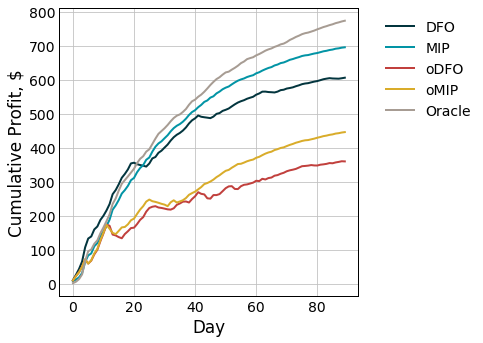

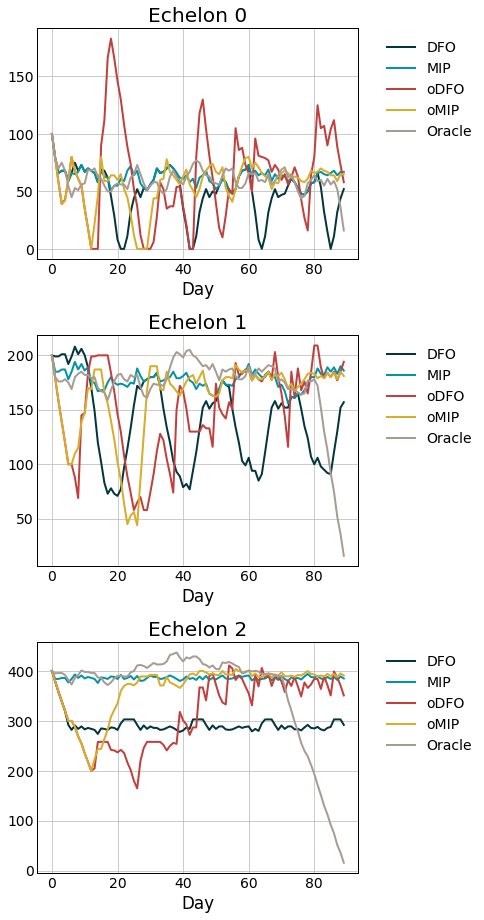

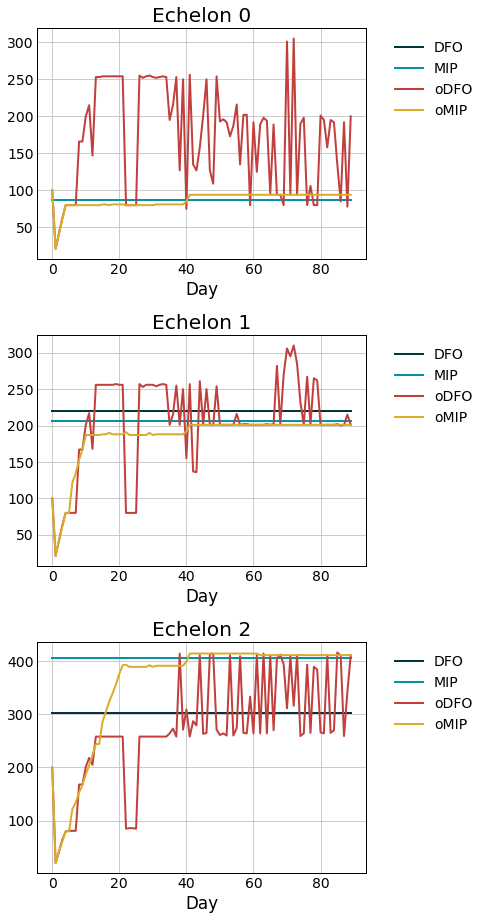

In [23]:
#extract pickle
import pickle
file_env_1 = open('NV_envs_LS_part1.obj','rb')
NV_envs_1 = pickle.load(file_env_1)
file_env_2 = open('NV_envs_LS_part2.obj','rb')
NV_envs_2 = pickle.load(file_env_2)
file_env_3 = open('NV_envs_LS_part3.obj','rb')
NV_envs_3 = pickle.load(file_env_3)
file_env_4 = open('NV_envs_LS_part4.obj','rb')
NV_envs_4 = pickle.load(file_env_4)
NV_envs = {}
NV_envs.update(NV_envs_1)
NV_envs.update(NV_envs_2)
NV_envs.update(NV_envs_3)
NV_envs.update(NV_envs_4)

env1_dfo = NV_envs['DFO']
env1_mip = NV_envs['MIP']
env1_dfo_online = NV_envs['oDFO']
env1_mip_online = NV_envs['oMIP']
env1_mip_pi = NV_envs['Oracle']

#plot results for backlog scenario

#profit
fig = plt.figure(figsize=[7,5])
plt.plot(np.cumsum(env1_dfo.P),label='DFO')
plt.plot(np.cumsum(env1_mip.P),label='MIP')
plt.plot(np.cumsum(env1_dfo_online.P),label='oDFO')
plt.plot(np.cumsum(env1_mip_online.P),label='oMIP')
plt.plot(np.cumsum(env1_mip_pi.P),label='Oracle')
plt.xlabel('Day')
plt.ylabel('Cumulative Profit, $')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('NewsVendor_LostSales.png')
plt.show()

#base stock levels
N = env1_dfo.num_periods
M = env1_dfo.num_stages

def inventory_position(I,T,B,stage):
    return np.sum(I[:-1,:stage+1] + T[:-1,:stage+1] - np.row_stack((np.zeros(stage+1),B[:-1,:i+1])),axis=1)

fig, axs = plt.subplots(3,1,figsize=[7,13])
axs = axs.ravel()
for i in range(M-1):
    axs[i].set_title('Echelon %i' %i)
    axs[i].set_xlabel('Day')
    
    #plot actual inventory positions
    axs[i].plot(inventory_position(I = env1_dfo.I, T = env1_dfo.T, B = env1_dfo.B, stage = i),label='DFO')
    axs[i].plot(inventory_position(I = env1_mip.I, T = env1_mip.T, B = env1_mip.B, stage = i),label='MIP')
    axs[i].plot(inventory_position(I = env1_dfo_online.I, T = env1_dfo_online.T, B = env1_dfo_online.B, stage = i),label='oDFO')
    axs[i].plot(inventory_position(I = env1_mip_online.I, T = env1_mip_online.T, B = env1_mip_online.B, stage = i),label='oMIP')
    axs[i].plot(inventory_position(I = env1_mip_pi.I, T = env1_mip_pi.T, B = env1_mip_pi.B, stage = i),label='Oracle')
    axs[i].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('NewsVendor_LostSales_inventory.png')
plt.show()

NV_envs['oDFO zopt']=np.array([list(NV_envs['oDFO zopt'][i]) for i in range(len(NV_envs['oDFO zopt']))])
NV_envs['oMIP zopt']=np.array([list(NV_envs['oMIP zopt'][i]) for i in range(len(NV_envs['oMIP zopt']))])

fig, axs = plt.subplots(3,1,figsize=[7,13])
axs = axs.ravel()
for i in range(M-1):
    axs[i].set_title('Echelon %i' %i)
    axs[i].set_xlabel('Day')

    #plot base stock levels
    axs[i].plot(NV_envs['DFO zopt'][i]*np.ones(N),label='DFO')
    axs[i].plot(NV_envs['MIP zopt'][i]*np.ones(N),label='MIP')
    axs[i].plot(NV_envs['oDFO zopt'][:,i],label='oDFO')
    axs[i].plot(NV_envs['oMIP zopt'][:,i],label='oMIP')
    axs[i].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('NewsVendor_LostSales_zopt.png')
plt.show()